In [1]:
!conda info --envs

# conda environments:
#
                         C:\DDRIVE\ProgramData\Anaconda3
                         C:\DDRIVE\ProgramData\Anaconda3\envs\GCP
base                  *  C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire



In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import csv
import numpy as np
import os
import sqlite3
import copy
from dbfread import DBF
import geopandas as gpd
import fiona
import pprint
import folium
import descartes
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import rasterio.mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import pickle
from scipy import stats
from raster2xyz.raster2xyz import Raster2xyz

print(f"Python Version = {sys.version}")
print(f"Pandas Version = {pd.__version__}")
print(f"Geopandas Version = {gpd.__version__}")
print(f"rasterio version = {rio._base.gdal_version()}")

Python Version = 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 21:48:41) [MSC v.1916 64 bit (AMD64)]
Pandas Version = 1.0.1
Geopandas Version = 0.6.3
rasterio version = 3.0.4


# Definitions

1) Fine Fuel Moisture Code
The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

2) Duff Moisture Code
The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.

3) Drought Code
The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.

4)  Initial Spread Index
The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

5) Temp
Temperature in Celsius degrees

6) RH
Relative humidity in %

7) Wind
Wind speed in km/h

8) Rain
Outside rain in mm/m2

9) Area
The burned area of the forest (in ha), ha = hectare = 2.47 acres

10) X
x-axis spatial coordinate within the Montesinho park map: 1 to 9 2

11) Y
y-axis spatial coordinate within the Montesinho park map: 2 to 9 3

Literature:

https://news.uci.edu/2019/09/17/uci-team-uses-machine-learning-to-help-tell-which-wildfires-will-burn-out-of-control/

In the original paper (Portugal - Montesinho fires), the best result (predicting burned area) was only using the 4 weather conditions: RH/Wind/Rain/Temp, and an SVM.

This: https://datasetsearch.research.google.com/search?query=wildfire%20area&docid=fchFFzqh0O3qjX3PAAAAAA%3D%3D has georeferenced and date/time referenced with areas. Could combine with weather data for those dates/times.

# Query shape of datasets, type, feature names and how they work together

In [ ]:
os.getcwd()

## Montesinho

In [ ]:
montesinho = pd.read_csv('../data/Montesinho/forestfires.csv')

In [ ]:
print(montesinho.shape)
montesinho.head()

## US Fires 1.88 Million

In [ ]:
db = sqlite3.connect('../data/188millionuswildfires/FPA_FOD_20170508.sqlite')

In [ ]:
cursorobj = db.cursor()
cursorobj.execute('SELECT name from sqlite_master where type = "table"')
tables1 = cursorobj.fetchall()
tables1

In [ ]:
tables2 = copy.deepcopy(tables1)
del tables2[18:21]
tables2
del tables2[19]
tables2

In [ ]:
for table in tables2:
    query = "SELECT * FROM " + table[0]
    #print(query)
    cursorobj.execute(query)
    names = [description[0] for description in cursorobj.description]
    print(table, names)

In [ ]:
usfires2 = pd.read_sql_query("SELECT datetime(DISCOVERY_DATE) as DISCOVERY_DATE, \
                             DISCOVERY_TIME, FIRE_SIZE, LATITUDE, LONGITUDE, \
                             datetime(CONT_DATE) as CONT_DATE, CONT_TIME \
                             FROM Fires",db)

In [ ]:
usfires2.shape

In [ ]:
usfires2.head()

In [ ]:
usfires2['logArea'] = usfires2.apply(lambda row: np.log(row.FIRE_SIZE+1), axis=1)

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(16,8))
usfires2.hist(column = "FIRE_SIZE", bins=100, ax = axes[0])
usfires2.hist(column = 'logArea', bins=100, ax=axes[1])
plt.show()

In [ ]:
geomac = sqlite3.connect('../data/188millionuswildfires/FPA_FOD_20170508.sqlite')

## Weather Data

1) cheapest seems to be DarkSky. 1000 per day for free
2) $0.0001 per request after that
3) Request: "
https://api.darksky.net/forecast/[key]/40.036944,-121.005833,2005-02-02T17:30:00"  (my api key removed)

Output is like this:
{"latitude":40.036944,"longitude":-121.005833,"timezone":"America/Los_Angeles","currently":{"time":1107394200,"precipIntensity":0,"precipProbability":0,"temperature":50.24,"apparentTemperature":50.41,"dewPoint":13.85,"humidity":0.23,"windSpeed":2.62,"windGust":13.17,"windBearing":24,"uvIndex":0},"hourly":{"data":[{"time":1107331200,"precipIntensity":0,"precipProbability":0,"temperature":39.73,"apparentTemperature":39.73,"dewPoint":12.45,"humidity":0.32,"windSpeed":1.23,"windGust":6.42,"windBearing":140,"uvIndex":0},{"time":1107334800,"precipIntensity":0,"precipProbability":0,"temperature":39.57,"apparentTemperature":39.57,"dewPoint":11.95,"humidity":0.32,"windSpeed":2.21,"windGust":5.8,"windBearing":72,"uvIndex":0},{"time":1107338400,"precipIntensity":0,"precipProbability":0,"temperature":38.69,"apparentTemperature":34.34,"dewPoint":13.27,"humidity":0.35,"windSpeed":5.79,"windGust":14.19,"windBearing":82,"uvIndex":0},{"time":1107342000,"precipIntensity":0,"precipProbability":0,"temperature":37.04,"apparentTemperature":37.04,"dewPoint":12.65,"humidity":0.36,"windSpeed":2.35,"windGust":9.56,"windBearing":98,"uvIndex":0},{"time":1107345600,"precipIntensity":0,"precipProbability":0,"temperature":36.26,"apparentTemperature":36.26,"dewPoint":12.71,"humidity":0.37,"windSpeed":1.16,"windGust":7.66,"windBearing":58,"uvIndex":0},{"time":1107349200,"precipIntensity":0,"precipProbability":0,"temperature":36.51,"apparentTemperature":36.51,"dewPoint":13.58,"humidity":0.39,"windSpeed":2.18,"windGust":6.93,"windBearing":71,"uvIndex":0},{"time":1107352800,"precipIntensity":0,"precipProbability":0,"temperature":36.4,"apparentTemperature":36.4,"dewPoint":12.17,"humidity":0.36,"windSpeed":2.48,"windGust":5.45,"windBearing":16,"uvIndex":0},{"time":1107356400,"precipIntensity":0,"precipProbability":0,"temperature":36.36,"apparentTemperature":36.36,"dewPoint":13.45,"humidity":0.39,"windSpeed":1.74,"windGust":5.3,"windBearing":61,"uvIndex":0},{"time":1107360000,"precipIntensity":0,"precipProbability":0,"temperature":35.85,"apparentTemperature":35.85,"dewPoint":14.88,"humidity":0.42,"windSpeed":2.52,"windGust":6.53,"windBearing":87},{"time":1107363600,"precipIntensity":0,"precipProbability":0,"temperature":42.06,"apparentTemperature":40.19,"dewPoint":13.16,"humidity":0.3,"windSpeed":3.48,"windGust":8.05,"windBearing":91},{"time":1107367200,"precipIntensity":0,"precipProbability":0,"temperature":46.17,"apparentTemperature":46.17,"dewPoint":16.52,"humidity":0.3,"windSpeed":2.71,"windGust":7.32,"windBearing":126},{"time":1107370800,"precipIntensity":0,"precipProbability":0,"temperature":47.55,"apparentTemperature":47.55,"dewPoint":21.59,"humidity":0.36,"windSpeed":2.72,"windGust":10.31,"windBearing":150},{"time":1107374400,"precipIntensity":0,"precipProbability":0,"temperature":52.04,"apparentTemperature":52.04,"dewPoint":20.52,"humidity":0.29,"windSpeed":4.29,"windGust":8.13,"windBearing":87},{"time":1107378000,"precipIntensity":0,"precipProbability":0,"temperature":55.54,"apparentTemperature":55.54,"dewPoint":19.53,"humidity":0.24,"windSpeed":4.84,"windGust":11.03,"windBearing":149},{"time":1107381600,"precipIntensity":0,"precipProbability":0,"temperature":56.34,"apparentTemperature":56.34,"dewPoint":17.37,"humidity":0.21,"windSpeed":5.54,"windGust":11.23,"windBearing":188},{"time":1107385200,"precipIntensity":0,"precipProbability":0,"temperature":57.34,"apparentTemperature":57.34,"dewPoint":15.65,"humidity":0.19,"windSpeed":6.36,"windGust":12.71,"windBearing":107},{"time":1107388800,"precipIntensity":0,"precipProbability":0,"temperature":53.57,"apparentTemperature":53.57,"dewPoint":15.64,"humidity":0.22,"windSpeed":6.13,"windGust":14.53,"windBearing":36},{"time":1107392400,"precipIntensity":0,"precipProbability":0,"temperature":52.58,"apparentTemperature":52.58,"dewPoint":14.07,"humidity":0.21,"windSpeed":3.32,"windGust":14.57,"windBearing":35},{"time":1107396000,"precipIntensity":0,"precipProbability":0,"temperature":47.79,"apparentTemperature":47.79,"dewPoint":13.74,"humidity":0.25,"windSpeed":2.6,"windGust":11.96,"windBearing":13,"uvIndex":0},{"time":1107399600,"precipIntensity":0,"precipProbability":0,"temperature":45.91,"apparentTemperature":43.25,"dewPoint":12.96,"humidity":0.26,"windSpeed":5.25,"windGust":13.55,"windBearing":80,"uvIndex":0},{"time":1107403200,"precipIntensity":0,"precipProbability":0,"temperature":43.25,"apparentTemperature":41.58,"dewPoint":14.25,"humidity":0.31,"windSpeed":3.45,"windGust":8.79,"windBearing":55,"uvIndex":0},{"time":1107406800,"precipIntensity":0,"precipProbability":0,"temperature":43.79,"apparentTemperature":43.79,"dewPoint":14.86,"humidity":0.31,"windSpeed":1.71,"windGust":6.29,"windBearing":158,"uvIndex":0},{"time":1107410400,"precipIntensity":0,"precipProbability":0,"temperature":42.36,"apparentTemperature":42.36,"dewPoint":14.51,"humidity":0.32,"windSpeed":2.37,"windGust":12.25,"windBearing":43,"uvIndex":0},{"time":1107414000,"precipIntensity":0,"precipProbability":0,"temperature":41.2,"apparentTemperature":41.2,"dewPoint":12.53,"humidity":0.31,"windSpeed":1.56,"windGust":12.79,"windBearing":100,"uvIndex":0}]},"daily":{"data":[{"time":1107331200,"sunriseTime":1107357120,"sunsetTime":1107393960,"moonPhase":0.78,"precipIntensity":0,"precipIntensityMax":0,"precipProbability":0,"temperatureHigh":57.95,"temperatureHighTime":1107384600,"temperatureLow":38.42,"temperatureLowTime":1107439200,"apparentTemperatureHigh":57.45,"apparentTemperatureHighTime":1107384600,"apparentTemperatureLow":38.91,"apparentTemperatureLowTime":1107439200,"dewPoint":14.85,"humidity":0.31,"windSpeed":3.33,"windGust":14.83,"windGustTime":1107390840,"windBearing":76,"uvIndex":0,"uvIndexTime":1107331200,"temperatureMin":35.03,"temperatureMinTime":1107359100,"temperatureMax":57.95,"temperatureMaxTime":1107384600,"apparentTemperatureMin":34.3,"apparentTemperatureMinTime":1107338640,"apparentTemperatureMax":57.45,"apparentTemperatureMaxTime":1107384600}]},"flags":{"sources":["cmc","gfs","hrrr","icon","isd","madis","nam","sref"],"nearest-station":3.312,"units":"us"},"offset":-8}

## Global Fire Data  

If you want to see these easily on a map, visit: https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1642  

I have only pulled the 2016 data in in order to get a feel for it.

### DBF file

#### Ignitions

In [ ]:
globaldbf = DBF('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.dbf')

In [ ]:
len(globaldbf)

In [ ]:
records = list(globaldbf)

In [ ]:
print(records[0])

In [ ]:
df = pd.DataFrame(iter(globaldbf))

In [ ]:
df.head()

#### Perimeter

In [ ]:
perim2016 = DBF('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.dbf')

In [ ]:
perimdf = pd.DataFrame(iter(perim2016))

In [ ]:
perimdf.head()

### Shapefile - shp

#### Ignitions

In [ ]:
with fiona.open('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp') as src:
    pprint.pprint(src[0])

In [ ]:
gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp')

In [ ]:
gdf.head()

In [ ]:
#gdf.plot()

In [ ]:
gdf.geometry[:5]

In [ ]:
print(gdf.crs)

In [ ]:
gdf.columns.values

#### Perimeter

In [ ]:
gdf1 = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp')

In [ ]:
gdf1.head()

In [ ]:
gdf1.columns.values

In [ ]:
gdf1.geometry[0]

In [ ]:
gdf1[0:3].plot()

In [ ]:
%%time
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgrey',linewidth=0.5,edgecolor='white',figsize = (20,8))
gdf1.plot(ax=ax)
plt.savefig('perimeters.png')

#### Combine Geom Ignition and Perimeter columns into single dataframe. pickle out

In [ ]:
perims = gdf1['geometry']

In [ ]:
geomsdf = copy.deepcopy(gdf)

In [ ]:
geomsdf.rename(columns={'geometry':'ignition_pt'},inplace=True)

In [ ]:
geomsdf['perimeter']=perims

In [ ]:
%%time
with open('../data/GlobalFire2016/Global_fire_atlas_V1_combined2016.pickle','wb') as f:
    pickle.dump(geomsdf,f,pickle.HIGHEST_PROTOCOL)

### PRJ file

In [ ]:
with open('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.prj') as f1:
    print(f"Ignitions Prj file contents = {f1.read()}")
    
with open('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.prj','r') as f2:
    print(f"Perimeter Prj file contents = {f2.read()}")    

The above mean:
- GEOGCS: Geographic coordinate reference system (vs. a projected coordinate system)
- WGS 84 : the name of the geographic coordinate reference system
- WGS_1984: The name of the DATUM
- SPHEROID: Used for the reference system with the semi major axis = 6378137 m and inverse-flattening ratio of 298.257223563
- PRIMEM: Greenwich is prime meridian where longitude is set as 0
- UNIT: measurement units of coordinate system, in degrees, where 0.01745.. is the conversion from radians to the units here(degrees)

### GEOTiff

#### Monthly TIFF (averages)

In [ ]:
dirmth = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_monthly_2016.tif')
dirmth

In [ ]:
print("name = ",dirmth.name)
print("mode = ",dirmth.mode)
print("closed? = ",dirmth.closed)
print("resolution of a pixel in units of coord reference system = ",dirmth.res)
print("Image Structure tags =",dirmth.tags(ns='IMAGE_STRUCTURE'))
print("tags =",dirmth.tags())
dirmth.meta

In [ ]:
dirmth.close()

In [ ]:
dirmth.closed

In [ ]:
print(dirmth.shape)
print(dirmth.bounds)
print("number of layers = ",dirmth.count)
print("number of bands", dirmth.indexes)

In [ ]:
dirmth_1 = dirmth.read(1)

In [ ]:
dirmth_1.shape

In [ ]:
plt.imshow(dirmth_1, cmap='summer')
plt.show()

In [ ]:
array = dirmth.read()
array.shape

In [ ]:
for i, dtype, nodataval in zip(dirmth.indexes, dirmth.dtypes, dirmth.nodatavals):
    print(i, dtype, nodataval)

#### Yearly TIFFs

In [28]:
from rasterio.windows import Window

In [29]:
%%time
diryr = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif')
speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')

Wall time: 116 ms


In [ ]:
tifs = [diryr,speedyr,dobyr,firelineyr]

In [ ]:
for tif in tifs:
    print("name = ",tif.name)
    print("resolution of a pixel in units of coord reference system = ",tif.res)
    print("Image Structure tags =",tif.tags(ns='IMAGE_STRUCTURE'))
    print("tags =",tif.tags())
    print(tif.shape)
    print(tif.bounds)
    print("number of layers = ",tif.count)
    print("number of bands =", tif.indexes)
    print(tif.meta)
    print("\n\n")

In [34]:
print(diryr.meta)
#customcrs = diryr.meta

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 81600, 'height': 31200, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(463.3127165279165, 0.0, -20015109.354,
       0.0, -463.3127165279167, 7783653.637666)}


In [35]:
print(diryr.crs)

PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [36]:
customcrs = diryr.crs

#### Relate TIFF data to a specific fire  

Basically we need to relate a latitude longitude of a specific ignition point (from the yearly ignition file) to a pixel, then use the pixel data to determine the fire spread of that specific fire over time.

In [6]:
# 2016 yearly data from pickle file
gdf_2016 = pd.read_pickle('../data/GlobalFire2016/Global_fire_atlas_V1_combined2016.pickle')

In [7]:
# Subset df for Fort McMurray fire
ftmc1 = gdf_2016.loc[(gdf_2016['latitude'] > 54.0) & (gdf_2016['latitude'] < 57.0)
                    & (gdf_2016['longitude'] > -113) & (gdf_2016['longitude'] < -110)]
pd.set_option('display.max_rows',86)
ftmc = copy.deepcopy(ftmc1)
ftmc.rename(columns={'perimeter':'geometry'},inplace=True)
ftmc.sort_values(by=['duration'],ascending=False)

,fire_ID,latitude,longitude,size,geometry,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,ignition_pt
34569,34570,56.6604,-111.410,1547.32,"POLYGON ((-110.20500 56.80417, -110.19739 56.8...",2016-05-01,122,2016-05-29,150,29,53.36,68.30,13.21,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-111.41070 56.66044)
34587,34588,56.7563,-110.273,129.91,"POLYGON ((-110.12625 56.82917, -110.11863 56.8...",2016-05-15,136,2016-06-08,160,25,5.20,5.22,13.34,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.27352 56.75627)
34540,34541,56.6479,-111.676,369.79,"POLYGON ((-110.39716 56.94167, -110.38952 56.9...",2016-05-12,133,2016-06-04,156,24,15.41,12.94,16.94,8,northwest,1,Evergreen Needleleaf forest,h11v03,POINT (-111.67692 56.64794)
34541,34542,56.6438,-111.694,110.83,"POLYGON ((-110.07299 56.92500, -110.06535 56.9...",2016-05-12,133,2016-06-04,156,24,4.62,6.37,5.94,7,west,1,Evergreen Needleleaf forest,h11v03,POINT (-111.69489 56.64377)
34575,34576,56.8188,-110.069,10.72,"POLYGON ((-111.57656 56.77917, -111.56135 56.7...",2016-05-20,141,2016-06-12,164,24,0.45,0.95,1.69,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.06913 56.81877)
34698,34699,56.3188,-110.524,49.52,"POLYGON ((-121.47017 56.31250, -121.46266 56.3...",2016-05-06,127,2016-05-27,148,22,2.25,2.93,6.71,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.52454 56.31877)
34559,34560,56.7646,-110.989,71.17,"POLYGON ((-110.76701 56.90417, -110.75175 56.9...",2016-05-15,136,2016-06-04,156,21,3.39,5.73,5.37,8,northwest,1,Evergreen Needleleaf forest,h11v03,POINT (-110.98981 56.76460)
34570,34571,56.6313,-110.468,74.17,"POLYGON ((-110.66162 56.80417, -110.60074 56.8...",2016-05-04,125,2016-05-24,145,21,3.53,4.67,6.57,7,west,1,Evergreen Needleleaf forest,h11v03,POINT (-110.46855 56.63127)
34582,34583,56.6854,-110.892,204.29,"MULTIPOLYGON (((-110.48313 56.78750, -110.4755...",2016-05-04,125,2016-05-24,145,21,9.73,14.97,11.28,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.89292 56.68544)
34581,34582,56.7479,-110.401,16.29,"MULTIPOLYGON (((-110.46106 56.75417, -110.4078...",2016-05-04,125,2016-05-24,145,21,0.78,1.61,1.97,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.40104 56.74794)


Pick fire # 34570 - that's the biggie.

In [8]:
fire = ftmc.loc[ftmc['fire_ID']==34570]
fire

,fire_ID,latitude,longitude,size,geometry,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,ignition_pt
34569,34570,56.6604,-111.41,1547.32,"POLYGON ((-110.20500 56.80417, -110.19739 56.8...",2016-05-01,122,2016-05-29,150,29,53.36,68.3,13.21,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-111.41070 56.66044)


In [ ]:
iy = np.array(fire['latitude'].values[0])
ix = np.array(fire['longitude'].values[0])

In [ ]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

ax.plot(ix,iy,marker='x',markersize=12,color='green')
ax.set_xlim([-110.21,-110.18])
ax.set_ylim([56.79,56.81])

fire.plot(ax=ax)

plt.show()

### CANNOT SEEM TO GET THE IGNITION POINT TO SHOW ON THE PLOT. GEOPANDAS DOES DIFFERENT STUFF WITH matplotlib

#### Convert TIFF raster file to point data  

This is NOT what we need to do -  basically we need to convert the points / polygons from the shapefile into the raster CRS.

In [ ]:
# From https://pypi.org/project/raster2xyz/
# input_raster = "input_raster.tif"
# out_csv = "/tmp/out_xyz.csv"

# rtxyz = Raster2xyz()
# rtxyz.translate(input_raster, out_csv)

input_raster = "../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif"
out_csv = "../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_out_xyz.csv"

rtxyz = Raster2xyz()
rtxyz.translate(input_raster, out_csv)

In [ ]:
raster_csv = pd.read_csv('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_out_xyz.csv')
raster_csv.shape

In [ ]:
raster_csv.head()

Spatial Reference System, proj4: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs

#### Convert Lat/Long to CRS

From StackExchange:

You need to transform your points to the coordinate system of the raster. You could warp the raster to your points' coordinate system but warping rasters is a bit messy. (for R but should be similar in python)

https://gis.stackexchange.com/questions/200417/very-basic-question-on-extracting-data-from-tif-raster-layer-in-r-projection-n

In [9]:
# Our desired 'fire' from the shapefile
fire

,fire_ID,latitude,longitude,size,geometry,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,ignition_pt
34569,34570,56.6604,-111.41,1547.32,"POLYGON ((-110.20500 56.80417, -110.19739 56.8...",2016-05-01,122,2016-05-29,150,29,53.36,68.3,13.21,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-111.41070 56.66044)


In [10]:
fire.crs

{'init': 'epsg:4326'}

In [11]:
# Global Fire Atlas projection Coordinate Reference System (from website)
gfacrs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs" 

In [12]:
fire2 = fire.to_crs(gfacrs)
fire2

C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,fire_ID,latitude,longitude,size,geometry,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,ignition_pt
34569,34570,56.6604,-111.41,1547.32,"POLYGON ((-6709231.448 6316342.264, -6708768.1...",2016-05-01,122,2016-05-29,150,29,53.36,68.3,13.21,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-111.41070 56.66044)


In [17]:
fire2.geometry.name

'geometry'

In [19]:
fire2.crs  # Ah that is why you can't convert two columns. because when you convert one column
# then the entire dataframe thinks it is now in the new CRS

'+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs'

#### Reimport and engineer the features appropriately

First, don't combine the shp files (as in 2.4.2.3). Instead, create 3 dataframes:  
1) fire ID and all the features (except geometry)  
2) fire ID and POLYGON  
3) fire ID and POINT (ignition)  

In [206]:
%%time
ign_gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp')
poly_gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp')

Wall time: 2min 30s


In [278]:
features1 = copy.deepcopy(ign_gdf)

In [279]:
features1 = pd.DataFrame(ign_gdf.drop(columns='geometry'))
features1.head()

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID
0,1,20.8438,-156.413,0.86,4.63,2016-10-26,300,2016-11-02,307,8,0.11,0.23,0.37,3,east,12,Croplands,h03v06
1,2,20.8396,-156.418,1.50,6.48,2016-10-28,302,2016-11-02,307,6,0.25,0.54,0.57,4,southeast,12,Croplands,h03v06
2,3,20.8105,-156.437,0.43,2.78,2016-11-29,334,2016-11-29,334,1,0.43,0.93,0.46,0,none,12,Croplands,h03v06
3,4,20.6271,-156.247,18.65,30.56,2016-02-16,47,2016-02-20,51,5,3.73,6.20,2.68,8,northwest,7,Open shrublands,h03v06
4,5,19.8063,-155.895,7.72,12.96,2016-03-20,80,2016-03-25,85,6,1.29,2.47,1.39,4,southeast,7,Open shrublands,h03v07


In [280]:
colnames = list(ign_gdf.columns)

In [281]:
keepnames = [colnames[0],colnames[len(colnames)-1]]
keepnames

['fire_ID', 'geometry']

In [282]:
dropnames = list(set(colnames) - set(keepnames))

In [283]:
ign_gdf.drop(columns=dropnames,inplace=True)

In [284]:
dropnames2 = list(set(list(poly_gdf.columns)) - set(keepnames))
poly_gdf.drop(columns=dropnames2,inplace=True)

In [285]:
# Global Fire Atlas projection Coordinate Reference System (from website)
gfacrs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs" 

#### Subset to California State

##### CA State Boundaries

From https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b

In [21]:
%%time
CA_gdf = gpd.read_file('../data/ca-state-boundary/CA_state_TIGER2016.shp')

Wall time: 111 ms


In [23]:
CA_gdf

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,"MULTIPOLYGON (((-13317677.375 3930590.808, -13..."


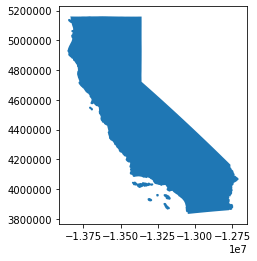

In [24]:
CA_gdf.plot()

In [37]:
#Convert to CRS
CA_gdf2 = CA_gdf.to_crs(customcrs)

C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


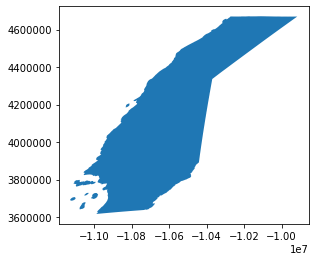

In [38]:
CA_gdf2.plot()

In [39]:
print(customcrs)

PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Well that sucks

##### Try a different approach - crop rasters to California

From Earth  data science: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/

In [286]:
# Raster Data opened by rio is diryr
print(diryr.bounds)

BoundingBox(left=-20015109.354, bottom=-6671703.118005, right=17791208.314677987, top=7783653.637666)


In [288]:
# Crop extent: CA_gdf
print('crop extent crs = \n', CA_gdf.crs)
print('tiff crs = \n', diryr.crs)

crop extent crs = 
 {'init': 'epsg:3857'}
tiff crs = 
 PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [289]:
# Set destination CRS
dst_crs = CA_gdf.crs

In [290]:
%%time
# Calculate the transform using the rasterio warp function
transform,width,height = calculate_default_transform(diryr.crs,dst_crs,diryr.width,diryr.height,*diryr.bounds)

Wall time: 121 ms


In [291]:
%%time
# Set the new meta data for the projected raster file
kwargs = diryr.meta.copy()
kwargs.update({'crs':dst_crs,
              'transform':transform,
              'width':width,
              'height':height
              })

Wall time: 1 ms


In [292]:
%%time
# write the new raster file by using the rasterio reproject function
with rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif','w',**kwargs) as dst:
    for i in range(1, diryr.count + 1):
        reproject(
            source = rio.band(diryr,i),
            destination=rio.band(dst,i),
            diryr_transform = diryr.transform,
            diryr_crs = diryr.crs,
            dst_transform = transform,
            dst_crs = dst_crs,
            resampling=Resampling.nearest)

Wall time: 10min 33s


In [295]:
%%time
# Open the new reprojected geotiff
diryr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif')
print(diryr_reproj.meta)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 78580, 'height': 38174, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -20037508.33380717,
       0.0, -509.9928633270912, 11068715.657331526)}
Wall time: 43 ms


In [296]:
%%time
# Crop extent: CA_gdf - crop to the boundaries of California, which should work now that both raster 
# and shapefile are on the same CRS
print('crop extent crs = \n', CA_gdf.crs)
print('tiff crs = \n', diryr_reproj.crs)

crop extent crs = 
 {'init': 'epsg:3857'}
tiff crs = 
 EPSG:3857
Wall time: 1e+03 µs


In [297]:
%%time
# Use the earthpy.spatial function to crop the tif by the shapefile
diryr_reproj_crop, diryr_reproj_crop_meta = es.crop_image(diryr_reproj,CA_gdf)

Wall time: 2.16 s


In [298]:
print("cropped data", diryr_reproj_crop.shape)
print("original data", diryr.shape)

cropped data (1, 2608, 2260)
original data (31200, 81600)


In [299]:
# Use the affine transformation for the CRS to define the extents
diryr_reproj_crop_affine = diryr_reproj_crop_meta["transform"]
diryr_reproj_extent = plotting_extent(diryr_reproj_crop[0],diryr_reproj_crop_affine)

In [300]:
diryr_reproj_crop_meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': -9999.0,
 'width': 2260,
 'height': 2608,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(509.9863732168427, 0.0, -13857493.46316547,
        0.0, -509.9928633270912, 5162488.3071404835)}

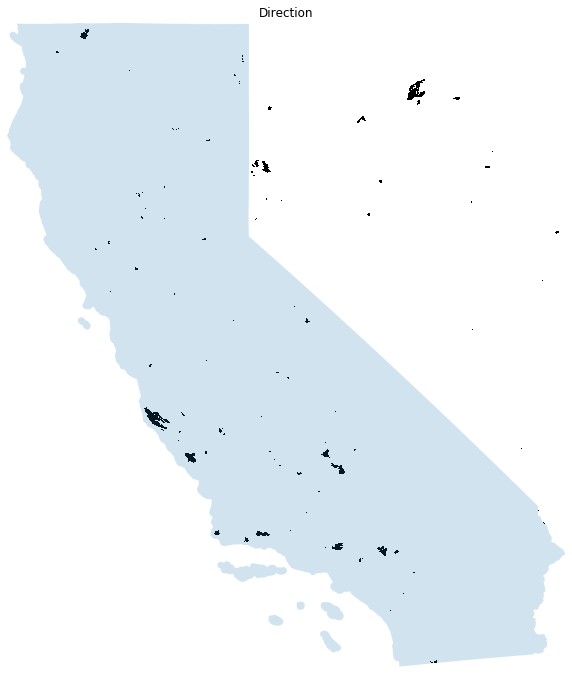

In [111]:
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax,alpha=0.2)
ax.set_axis_off()
plt.show()

In [301]:
vals = diryr_reproj_crop[0][diryr_reproj_crop[0]>0]
vals

array([5, 5, 4, ..., 4, 4, 4])

In [95]:
print(type(vals),vals.shape)
stats.describe(vals)

<class 'numpy.ndarray'> (18878,)


DescribeResult(nobs=18878, minmax=(1, 8), mean=4.827788960694989, variance=4.573986433819962, skewness=0.01438966604151448, kurtosis=-0.8866531007320164)

##### Transform Ignition and polygons of final fire sizes to CA CRS

In [109]:
# transform CRS
ign2 = ign_gdf.to_crs(dst_crs)
poly2 = poly_gdf.to_crs(dst_crs)

C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [114]:
# set area to crop to
bb = CA_gdf.envelope

In [116]:
# Crop polygons of final fire sizes using geopandas overlay
df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb),columns=['geometry'])
poly2crop = gpd.overlay(df2,poly2,how='intersection')

In [117]:
# Use dataframe slicing for the ignition point data.
xmin,ymin,xmax,ymax=CA_gdf.total_bounds
ign2crop = ign2.cx[xmin:xmax,ymin:ymax]

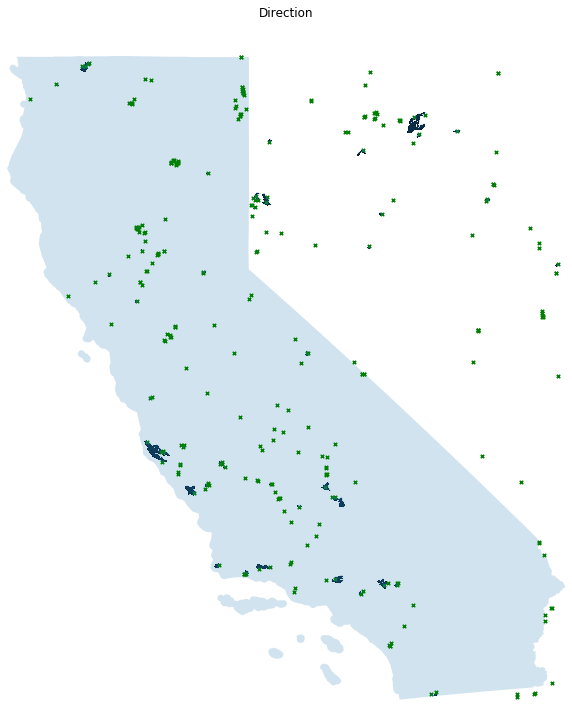

In [131]:
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax, alpha=0.2)
ign2crop.plot(ax=ax,marker='x',color='green',markersize=12)
poly2crop.plot(ax=ax,alpha=0.4)
ax.set_axis_off()
plt.show()

#### Create new bounding box for smaller section of CA and convert CRS
Repeat above process for cropping

In [155]:
# Set source CRS - this is the google maps CRS
bb_gdf_orig.crs = {'init':'epsg:4326'}
print(bb_gdf_orig.crs)

{'init': 'epsg:4326'}


In [165]:
# Create bounding box polygon from lat long pulled from Gmaps
from shapely.geometry import Polygon
bb_long = [-122, -119.912,-119.912,-122,-122 ]
bb_lat = [36.8, 36.8, 35.06, 35.06,36.8]
bb_poly = Polygon(zip(bb_long,bb_lat))
bb_gdf2 = gpd.GeoDataFrame(index=[0],crs=bb_gdf_orig.crs,geometry = [bb_poly])
print(bb_gdf2.geometry)

0    POLYGON ((-122.00000 36.80000, -119.91200 36.8...
Name: geometry, dtype: geometry


In [167]:
# Change CRS of polygon to match other work here
bb_gdf2 = bb_gdf2.to_crs(epsg=3857)
bb_gdf2

C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,geometry
0,"POLYGON ((-13580977.877 4411265.910, -13348542..."


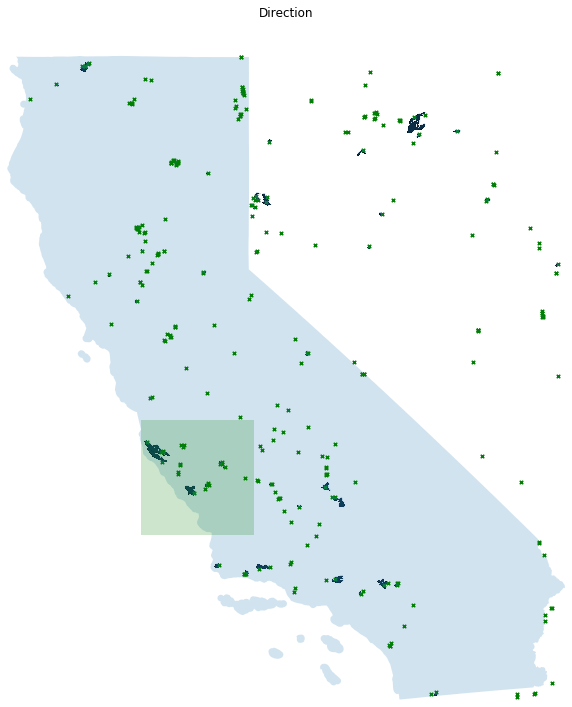

In [168]:
# Plotting
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax, alpha=0.2)
ign2crop.plot(ax=ax,marker='x',color='green',markersize=12)
poly2crop.plot(ax=ax,alpha=0.4)
bb_gdf2.plot(ax=ax,color='green',alpha=0.2)
ax.set_axis_off()
plt.show()

#### Convert CRS for remaining raster files

In [180]:
# Raster Data opened by rio 
#speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
#dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
#firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')
print('speedyr bounds =',speedyr.bounds)
print('dobyr bounds =',dobyr.bounds)
print('firelineyr bounds =',firelineyr.bounds)

speedyr bounds = BoundingBox(left=-20015109.354, bottom=-6671703.118005, right=17791208.314677987, top=7783653.637666)
dobyr bounds = BoundingBox(left=-20015109.354, bottom=-6671703.118005, right=17791208.314677987, top=7783653.637666)
firelineyr bounds = BoundingBox(left=-20015109.354, bottom=-6671703.118005, right=17791208.314677987, top=7783653.637666)


In [60]:
# Set destination CRS
dst_crs = bb_gdf2.crs

In [185]:
tifs = [(speedyr,'speed'),(dobyr,'dob'),(firelineyr,'fireline')]

In [187]:
# Commented out this whole box because files have been saved already NEXT TIME - ADD COMPRESSION - 
# FILES WERE HUGE (see commented line below) OR reproject to new array, then write out with compression
# %%time
# for tif in tifs:
#     file,name = tif
    
#     # Calculate the transform using the rasterio warp function
#     transform,width,height = calculate_default_transform(file.crs,dst_crs,file.width,file.height,*file.bounds)
    
#     # Set the new meta data for the projected raster file
#     kwargs = file.meta.copy()
#     kwargs.update({'crs':dst_crs,
#                   'transform':transform,
#                   'width':width,
#                   'height':height
#                   #compress:'lzw'
#                   })
    
#     # Filename for writing out to
#     filestring = '../data/GlobalFire2016/Global_fire_atlas_' + name + '_yearly_2016_reproj.tif'
    
#     # write the new raster file by using the rasterio reproject function
#     with rio.open(filestring,'w',**kwargs) as dst:
#         for i in range(1, file.count + 1):
#             reproject(
#                 source = rio.band(file,i),
#                 destination=rio.band(dst,i),
#                 file_transform = file.transform,
#                 file_crs = file.crs,
#                 dst_transform = transform,
#                 dst_crs = dst_crs,
#                 resampling=Resampling.nearest)  

In [302]:
# Close all the previous readers
diryr.close()
dobyr.close()
firelineyr.close()
speedyr.close()

#### Crop to smaller bounding box - Toy Set

In [303]:
# Check CRSs all match
print('ignition CRS', ign2.crs)
print('final polygon CRS', poly2.crs)
print('bounding box CRS', bb_gdf2.crs)

ignition CRS {'init': 'epsg:3857'}
final polygon CRS {'init': 'epsg:3857'}
bounding box CRS {'init': 'epsg:3857', 'no_defs': True}


##### First the ignition points to get fire numbers and then final fire sizes and dbf data

In [304]:
print('bounding box extents', bb_gdf2.total_bounds)

bounding box extents [-13580977.87677938   4172037.89674901 -13348542.78000302
   4411265.91026269]


In [305]:
# Crop Ignition Data
xmin2,ymin2,xmax2,ymax2=bb_gdf2.total_bounds
ign2crop2 = ign2.cx[xmin2:xmax2,ymin2:ymax2]

In [306]:
print(ign2crop2.shape, ign2.shape)

(22, 2) (887221, 2)


In [307]:
fires = ign2crop2['fire_ID'].values

In [308]:
poly2crop2 = poly2.loc[poly2['fire_ID'].isin(fires)]

In [309]:
print(poly2crop2.shape, poly2.shape)

(22, 2) (887251, 2)


In [310]:
featurescrop2 = features1.loc[features1['fire_ID'].isin(fires)]

In [342]:
featurescrop2.head()

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID
139,140,36.4604,-121.894,447.39,196.31,2016-07-21,203,2016-09-17,261,59,7.58,12.96,1.89,4,southeast,8,Woody savannas,h08v05
140,141,36.3271,-121.592,23.79,30.56,2016-09-15,259,2016-09-23,267,9,2.64,4.42,3.04,8,northwest,8,Woody savannas,h08v05
141,142,36.3188,-121.594,39.23,36.11,2016-09-15,259,2016-09-25,269,11,3.57,5.14,2.55,4,southeast,8,Woody savannas,h08v05
142,143,36.3146,-121.629,18.86,24.08,2016-09-17,261,2016-09-29,273,13,1.45,2.32,2.64,4,southeast,8,Woody savannas,h08v05
145,146,36.4188,-121.259,1.93,8.33,2016-04-09,100,2016-04-14,105,6,0.32,0.69,1.57,4,southeast,10,Grasslands,h08v05


In [343]:
ign2crop2.head()

,fire_ID,geometry
139,140,POINT (-13569190.649 4364164.207)
140,141,POINT (-13535572.325 4345725.240)
141,142,POINT (-13535852.045 4344573.853)
142,143,POINT (-13539733.596 4343998.206)
145,146,POINT (-13498502.587 4358398.631)


In [338]:
%%time
#pickle out the ignition points and dbf
with open('../data/GlobalFire2016/Global_fire_atlas_ignitioncrop.pickle','wb') as f:
    pickle.dump(ign2crop2,f,pickle.HIGHEST_PROTOCOL)
with open('../data/GlobalFire2016/Global_fire_atlas_datacrop.pickle','wb') as f:
    pickle.dump(featurescrop2,f,pickle.HIGHEST_PROTOCOL)

Wall time: 18 ms


##### Crop the rasters

In [256]:
# Open the new reprojected geotiffs
diryr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif')
speedyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016_reproj.tif')
dobyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_dob_yearly_2016_reproj.tif')
firelineyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_fireline_yearly_2016_reproj.tif')

In [311]:
# Crop extent: bb_gdf2 - crop to the small box, which should work now that both raster 
# and shapefile are on the same CRS
print('crop extent crs = ', bb_gdf2.crs)
print('direction tiff crs = ', diryr_reproj.crs)
print('speed tiff crs = ', speedyr_reproj.crs)
print('day of burn tiff crs = ', dobyr_reproj.crs)
print('fireline tiff crs = ', firelineyr_reproj.crs)

crop extent crs =  {'init': 'epsg:3857', 'no_defs': True}
direction tiff crs =  EPSG:3857
speed tiff crs =  EPSG:3857
day of burn tiff crs =  EPSG:3857
fireline tiff crs =  EPSG:3857


In [313]:
def crop_tif(tif_reproj,boundingbox):
    """function to crop the reprojected tiffs by the bounding box (shapefile)"""
    
    tif_reproj_crop,tif_reproj_crop_meta = es.crop_image(tif_reproj,boundingbox)
    print("cropped data", tif_reproj_crop.shape)
    print("original data", tif_reproj.shape)
    print("meta", tif_reproj_crop_meta)
       
    return(tif_reproj_crop, tif_reproj_crop_meta)

In [314]:
%%time
diryr_reproj_crop,diryr_reproj_crop_meta = crop_tif(diryr_reproj,bb_gdf2)
speedyr_reproj_crop,speedyr_reproj_crop_meta = crop_tif(speedyr_reproj,bb_gdf2)
dobyr_reproj_crop,dobyr_reproj_crop_meta = crop_tif(dobyr_reproj,bb_gdf2)
firelineyr_reproj_crop,firelineyr_reproj_crop_meta = crop_tif(firelineyr_reproj,bb_gdf2)

cropped data (1, 470, 456)
original data (38174, 78580)
meta {'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 456, 'height': 470, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)}
cropped data (1, 470, 456)
original data (38174, 78580)
meta {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 456, 'height': 470, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)}
cropped data (1, 470, 456)
original data (38174, 78580)
meta {'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 456, 'height': 470, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)}
cropped data (1, 470, 456)
original data (38174, 78580)
meta {'driver': 'GTiff', 'dtyp

In [318]:
vals = firelineyr_reproj_crop[0][firelineyr_reproj_crop[0]>0]
vals

array([208, 208, 208, ..., 232, 231, 231])

In [321]:
diryr_reproj.close()
speedyr_reproj.close()
dobyr_reproj.close()
firelineyr_reproj.close()

In [323]:
# Write these out to smaller tiffs
with rio.open('../data/GlobalFire2016/Global_fire_atlas_dircrop.tif','w',**diryr_reproj_crop_meta) as dst:
    dst.write(diryr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_speedcrop.tif','w',**speedyr_reproj_crop_meta) as dst:
    dst.write(speedyr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_dobcrop.tif','w',**dobyr_reproj_crop_meta) as dst:
    dst.write(dobyr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_firelinecrop.tif','w',**firelineyr_reproj_crop_meta) as dst:
    dst.write(firelineyr_reproj_crop)

#### Create a new tiff with fire_ID as the value
Determine if a raster pixel is in a fire polygon and create a new tiff with fire_ID as the value

In [324]:
# From https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python
polys = poly2crop2
rst_fn = '../data/GlobalFire2016/template.tif'
out_fn = '../data/GlobalFire2016/fireid.tif'

In [325]:
rst = rio.open(rst_fn)
metaout = rst.meta.copy()
metaout.update(compress='lzw')

In [327]:
with rio.open(out_fn, 'w+',**metaout) as out:
    out_arr = out.read(1)
    
    shapes = ((geom,value) for geom,value in zip(polys.geometry,polys.fire_ID))
    
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1,burned)

In [334]:
fireid = rio.open('../data/GlobalFire2016/fireid.tif')
print(fireid.meta)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 456, 'height': 470, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)}


In [332]:
fireid_array = fireid.read()

In [333]:
fireid_array.shape

(1, 470, 456)

In [344]:
print(fireid_array)

[[[-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  ...
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]]]


In [336]:
vals = fireid_array[0][fireid_array[0]>0]
vals

array([140, 140, 140, ..., 189, 189, 189])

In [341]:
len(vals)

4855

## Alberta

In [ ]:
alb_dbf = DBF('../data/Alberta/HistoricalWildfirePerimeters/WilfirePerimeters1931to2019.dbf')

In [ ]:
len(alb_dbf)

In [ ]:
dfalb = pd.DataFrame(iter(alb_dbf))
dfalb.head()

In [ ]:
alb_gdf = gpd.read_file('../data/Alberta/HistoricalWildfirePerimeters/WilfirePerimeters1931to2019.shp')

In [ ]:
alb_gdf.plot()

In [ ]:
alb_gdf.head()

## Geomac

### Event Polygon

In [ ]:
gmdbf = DBF('../data/GeoMac/EventPolygon.dbf', encoding='UTF-8')

In [ ]:
dfgmac = pd.DataFrame(iter(gmdbf))
#dfgmac[210:215]
#same data in shp file, shp file has geometry added. not showing this one

In [ ]:
gm_gdf = gpd.read_file('../data/GeoMac/EventPolygon.shp')

In [ ]:
pd.set_option('display.max_columns', 500)

In [ ]:
gm_gdf[210:215]

In [ ]:
gm_gdf.shape

In [ ]:
sortedgdf = gm_gdf.sort_values(by=['IRWINID'])
sortedgdf.head()

In [ ]:
gm_gdf.geometry[210]

## CWFIS Large Fires

In [ ]:
canlg_dbf = DBF('../data/CWFIS/NFDB_poly_20190607_large_fires.dbf',encoding='UTF-8')

In [ ]:
df_canlg = pd.DataFrame(iter(canlg_dbf))
df_canlg.shape

In [ ]:
df_canlg[20000:20015]

## BC

In [ ]:
bc_dbf = DBF('../data/BC/PROT_HISTORICAL_FIRE_POLYS_SP/H_FIRE_PLY_polygon.dbf',encoding='UTF-8')

In [ ]:
df_bc = pd.DataFrame(iter(bc_dbf))
df_bc.shape

In [ ]:
df1_bc = df_bc.sort_values(by=['FIRELABEL'])
df1_bc[20000:20010]